In [1]:
#Questions
# - dense layer?
# - model doing better with less layers?
# - tuning layers
# - construct a class to test model differences
# - visualize model flow?
# - visualize filter outputs?
# - modeling doing better during validation than training?

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


### Data Exploration

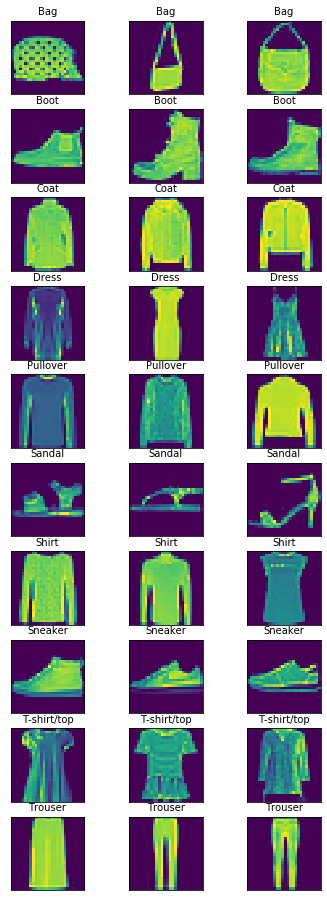

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot sample of categories
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10,3, figsize = (6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image)
    axes[i].set_title(grouped[1][i], size=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

### Data Processing and CNN

In [4]:
#scaling to ease computational burden of model
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float 32 to use less space, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels)
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [5]:
class CNN:
    """Takes in a model and returns model results"""
    def __init__(self, model_list):
        self.model_list = model_list
        
    def model_test(self, test_metric, test_val):
        model_list = self.model_list
        epochs=5
        start_time = time.time()
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        end_time = time.time()
        model_time = end_time - start_time

        model_output=model.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=1, 
                         shuffle=True, validation_split=0.2)
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['metric'] = test_metric
        history['test_val'] = str(test_val)
        return history
    
#when just a tuple, the len of kernels is 2
#when a list of a single tuple, the second model doesn't work
def model_list(kernels=[(5,5)], filters=10, layers = 'simple'):
    """function to create list of sequential models
    pass in list of tuples for kernel size, or list of scalars for number of filters"""
    if len(kernels) > 1:
        models=[]
        metric='kernels'
        for kernel in kernels:
            model = Sequential([Conv2D(filters=filters, kernel_size=kernel, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                              Flatten(),
                              Dense(10, activation='softmax')])
            models.append((model, kernel, 'kernel'))
        return models
            
    if len(filters) > 1:
        models=[]
        metric='filters'
        for filter_val in filters:
            model = Sequential([Conv2D(filters=filter_val, kernel_size=kernels[0], activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
                              Flatten(),
                              Dense(10, activation='softmax')])
            models.append((model, filter_val, 'filters'))
        return models

In [6]:
kernel_models = model_list(kernels=[(3,3),(5,5),(10,10),(28,28)])
filter_models = model_list(filters=(5,10,30,60))
models = kernel_models + filter_models
    
model_output = pd.DataFrame()
for model_values in models:
    model = model_values[0]
    test_val = model_values[1]
    test_metric = model_values[2]
    cnn = CNN(model)
    results = cnn.model_test(test_metric, test_val)
    model_output = model_output.append(results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 63us/step - loss: 0.5592 - accuracy: 0.8104 - val_loss: 0.4149 - val_accuracy: 0.8558
Epoch 2/5
48000/48000 [==============================] - 3s 54us/step - loss: 0.3840 - accuracy: 0.8665 - val_loss: 0.3669 - val_accuracy: 0.8725
Epoch 3/5
48000/48000 [==============================] - 3s 62us/step - loss: 0.3395 - accuracy: 0.8796 - val_loss: 0.3399 - val_accuracy: 0.8827
Epoch 4/5
48000/48000 [==============================] - 3s 63us/step - loss: 0.3114 - accuracy: 0.8900 - val_loss: 0.3290 - val_accuracy: 0.8851
Epoch 5/5
48000/48000 [==============================] - 3s 62us/step - loss: 0.2943 - accuracy: 0.8945 - val_loss: 0.3170 - val_accuracy: 0.8869
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 5s 95us/step - loss: 0.5446 - accuracy: 0.8083 - val_loss: 0.4222 - val_accuracy: 0.8509
Epoch 2/5
48000/48000 [=

In [38]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    """Creates a CNN object, which has methods create_model (to create CNN model) 
    and fit_model (to evaluate and record model results)"""
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']

    def fit_model(self, epochs=3, batch_size=100):
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        start_time = time.time()
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        end_time = time.time()
        model_time = end_time - start_time
        model_output=model.fit(x_train_scaled_shape, y_train_cat, batch_size=batch_size, epochs=epochs, verbose=1, 
                         shuffle=True, validation_split=0.2)
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history
    
    # # datagen = ImageDataGenerator(rotation_range=10,
# #                             zoom_range=0.1,
# #                             width_shift_range=0.1,
# #                             height_shift_range=0.1)

# # epochs = 3
# # batch_size = 100
# # history = model_kernel.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
# #                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


In [42]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model_results = cnn.fit_model(epochs=3)
    all_results = all_results.append(model_results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 5s 104us/step - loss: 0.5789 - accuracy: 0.8014 - val_loss: 0.4283 - val_accuracy: 0.8537
Epoch 2/3
48000/48000 [==============================] - 5s 108us/step - loss: 0.3999 - accuracy: 0.8614 - val_loss: 0.3778 - val_accuracy: 0.8702
Epoch 3/3
48000/48000 [==============================] - 6s 132us/step - loss: 0.3605 - accuracy: 0.8742 - val_loss: 0.3591 - val_accuracy: 0.8728
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 7s 140us/step - loss: 0.5320 - accuracy: 0.8163 - val_loss: 0.4139 - val_accuracy: 0.8541
Epoch 2/3
48000/48000 [==============================] - 5s 94us/step - loss: 0.3871 - accuracy: 0.8649 - val_loss: 0.3790 - val_accuracy: 0.8708
Epoch 3/3
48000/48000 [==============================] - 4s 91us/step - loss: 0.3483 - accuracy: 0.8774 - val_loss: 0.3531 - val_accuracy: 0.8735
Train on 48000 sampl

In [66]:
max_acc = all_results['accuracy'].max()
all_results[all_results['accuracy'] == max_acc]

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
2,0.303447,0.894417,0.283757,0.899188,3,0.026283,60,"(5, 5)"


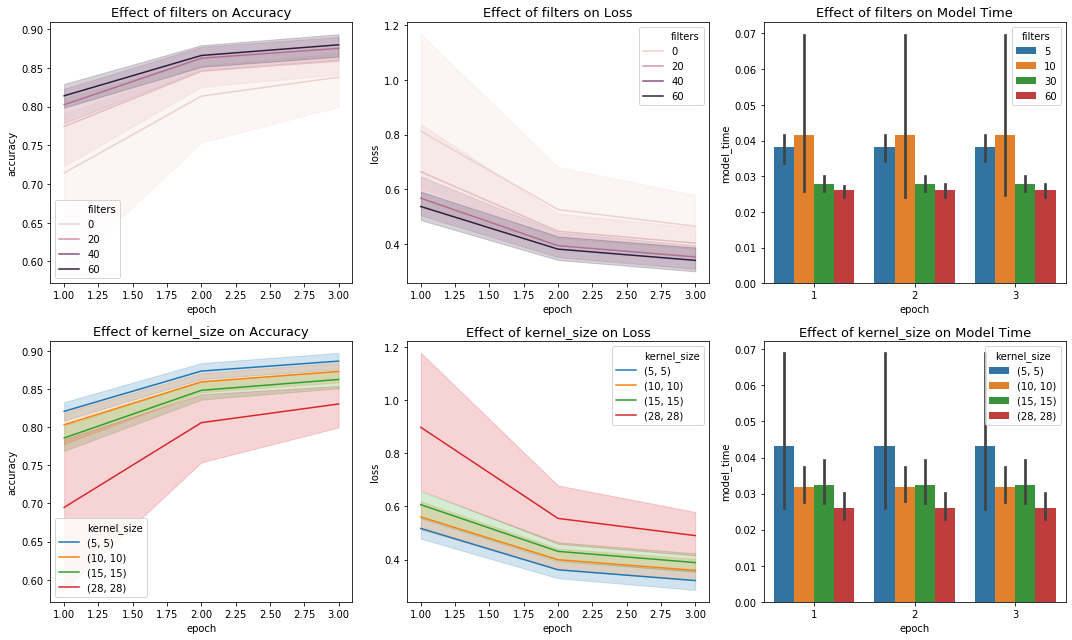

In [63]:
fig, axes = plt.subplots(2,3,figsize=(15,9))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*3])
    axes[i*3].set_title('Effect of '+metric+' on Accuracy',size=13)
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*3+1])
    axes[i*3+1].set_title('Effect of '+metric+' on Loss',size=13)
    sns.barplot('epoch','model_time',data=all_results, hue=metric, ax=axes[i*3+2])
    axes[i*3+2].set_title('Effect of '+metric+' on Model Time',size=13)
    plt.tight_layout()

### Prediction analysis

In [ ]:
#calculate predictions
predictions = model_kernel.predict(x_test_sample)

counts=Counter()
for x,y in zip(predictions, y_test):
    if np.argmax(x)==y:
        counts[y] +=1
        
counts

In [ ]:
#compare predicted to actuals
pred_labels = [np.argmax(x) for x in predictions]
pred_actual = pd.DataFrame(zip(y_test, pred_labels)).rename(columns={0:'actual', 1:'predicted'})
pred_actual['actual_label'] = pred_actual['actual'].map(categories)
pred_actual['predicted_label'] = pred_actual['predicted'].map(categories)
pred_actual['correct'] = pred_actual['actual'] == pred_actual['predicted']
pred_actual

pred_actual.groupby('actual_label')['correct'].aggregate({'sum':sum, 'total':len})

In [ ]:
test = incorrect.groupby(['actual_label','predicted_label'])['actual'].count().sort_values(ascending=False).to_frame()
test = test.reset_index()
test['labels'] = test['actual_label'] + '_'+ test['predicted_label']
test.head()

In [ ]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_actual[pred_actual['actual_label']!=pred_actual['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(7,7))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_actual.iloc[index]['actual_label']
    predicted_label = pred_actual.iloc[index]['predicted_label']
    axes[i].imshow(x_train_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=12)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()

In [ ]:
#plot frequency of accurate predictions by category
predicted = pd.DataFrame.from_dict(counts, orient='index').reset_index().rename(columns={'index':'label', 0:'count'})
predicted['item'] = predicted['label'].map(categories)
predicted = predicted.sort_values('count', ascending=False)
sns.barplot(predicted['item'], predicted['count'], palette='mako_r')
plt.title('Correct Predictions by Category')
ticks=plt.xticks(rotation='vertical')

In [ ]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')